<Axes: xlabel='timestamp'>

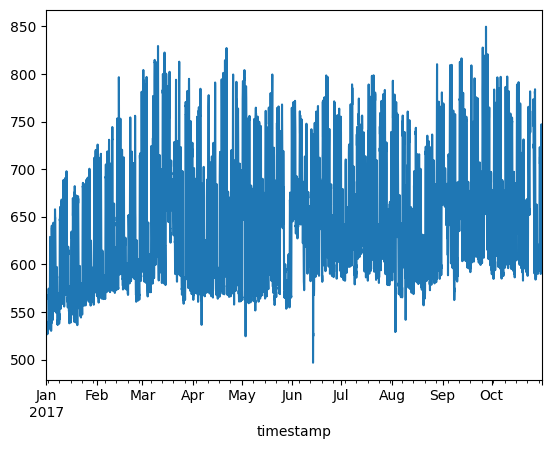

In [91]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import numpy as np
from sklearn.cluster import KMeans
import seaborn as sns
import calmap
from matplotlib.colors import ListedColormap, Normalize

building_df = pd.read_csv("data/building_5_weather_1_train.csv", parse_dates=['timestamp'])
weather_df = pd.read_csv("data/weather_1.csv", parse_dates=['timestamp'])

building_df.drop_duplicates(inplace=True)
building_df.set_index('timestamp',inplace=True)
weather_df.drop_duplicates(inplace=True)
weather_df.set_index('timestamp',inplace=True)

data = building_df.join(weather_df,how='left',on='timestamp')

data['hour'] = data.index.hour
#data['date'] = data.index.map(lambda t:t.strftime('%Y-%m-%d'))
data['date'] = data.index.date

data['power'].plot()



## Outliers

### Z-score Outlier

timestamp
2017-09-27 14:00:00    849.7478
Name: power, dtype: float64


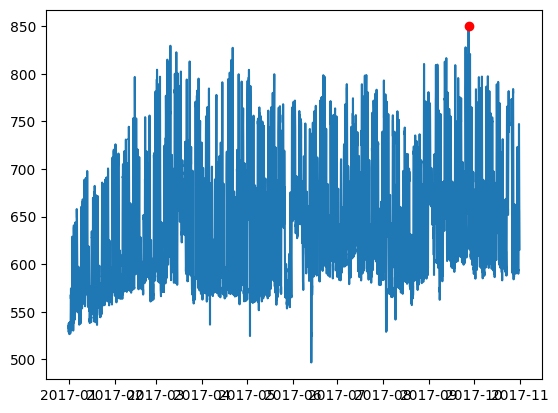

In [65]:
# calculate z-scores for each column
z_scores = (data['power'] - data['power'].mean()) / data['power'].std()

# define std limit (default 3)
std_limit = 3

# identify outliers as data points with z-score greater than std_limit or less than -std_limit
outliers = data['power'][(z_scores > std_limit) | (z_scores < -std_limit)]

print(outliers)

# plot column 'a' with outlier in red
plt.plot(data['power'])
plt.plot(outliers.index, data.loc[outliers.index, 'power'], 'ro')
plt.show()

outliers_z_score = outliers



### Boxplot interquantile

timestamp
2017-03-10 14:00:00    829.4961
2017-09-27 14:00:00    849.7478
Name: power, dtype: float64


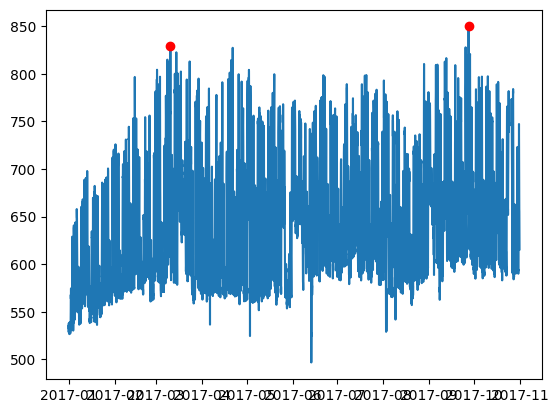

In [66]:
# evaluate 1st quartile
Q1 = data['power'].quantile(0.25)

# evalutate 3rd quartile
Q3 = data['power'].quantile(0.75)

# evaluate interquartile
IQR = Q3 - Q1

# define IQR limit (default 1.5)
IQR_limit = 1.5

# identify and highlight outliers
outliers = data['power'][(data['power'] < Q1 - IQR_limit*IQR) | (data['power'] > Q3 + IQR_limit*IQR)]

print(outliers)

plt.plot(data['power'])
plt.plot(outliers.index, data.loc[outliers.index, 'power'], 'ro')
plt.show()

outliers_interquantile = outliers

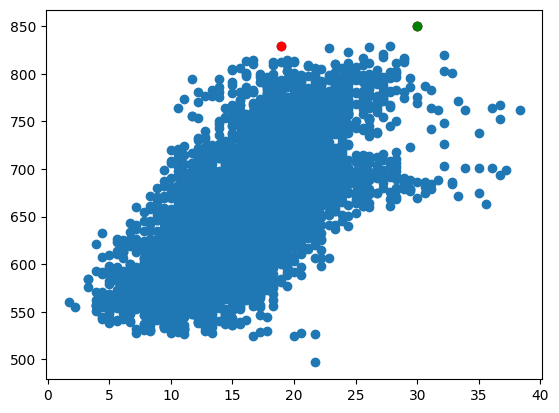

In [67]:
plt.scatter(data['airTemperature'],data['power'])
plt.scatter(data['airTemperature'].loc[outliers_interquantile.index],outliers_interquantile,c='red')
plt.scatter(data['airTemperature'].loc[outliers_z_score.index],outliers_z_score,c='green')
plt.show()

### Remove outliers

In [68]:
data.power.loc[outliers_z_score.index] = np.nan

data.head()

,power,airTemperature
timestamp,,
2017-01-01 00:00:00,537.1756,8.3
2017-01-01 01:00:00,528.6003,10.6
2017-01-01 02:00:00,532.4253,11.1
2017-01-01 03:00:00,535.8997,11.1
2017-01-01 04:00:00,531.9250,10.6


## NA

In [69]:
print(data['power'].isna().sum())
print(data['airTemperature'].isna().sum())

41
0


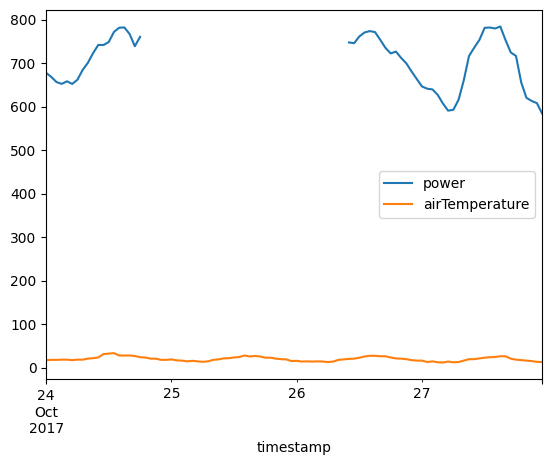

In [70]:
data[data['power'].isna()]

data["2017-10-24":"2017-10-27"].plot()

data['power'].interpolate('spline',limit=3,inplace=True,order=3)
data[data['power'].isna()]
data.dropna(subset=['power'],inplace=True)

## Data visualization

##  Load profiles characterization

In [76]:
data.index.duplicated().sum()

pv_data = data.pivot(index='date',columns='hour',values='power')

### K-Means

In [78]:
#pv_data.isna().sum()
pv_data.dropna(inplace= True)

In [79]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

k_range = [i for i in range(2,8)]
db_list = []
sh_list = []

for k in k_range:
  kmeans = KMeans(n_clusters=k,random_state=0).fit(pv_data)
  labels = kmeans.labels_
  db_list.append(silhouette_score(pv_data, labels))
  sh_list.append(davies_bouldin_score(pv_data, labels))

print(f"The best number of clusters according to Silhouette is {k_range[np.argmax(sh_list)]}")
print(f"The best number of clusters according to DB Index is {k_range[np.argmin(db_list)]}")

c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\itgiman10\Desktop\CORSO DATA SCIENCE\lezioni\esame\dataScienceCourse-group5\.venv\lib

The best number of clusters according to Silhouette is 7
The best number of clusters according to DB Index is 7


In [80]:
# Both metrics indicate 7 as the best number of cluster
K = 7
kmeans = KMeans(n_clusters=K, n_init='auto', random_state=0).fit(pv_data)
labels = kmeans.labels_
cluster_counts = np.unique(labels, return_counts=True)
cluster_counts


(array([0, 1, 2, 3, 4, 5, 6]),
 array([64, 31, 42, 59, 21, 19, 64], dtype=int64))

In [81]:
[pv_data.index]

[Index([2017-01-01, 2017-01-02, 2017-01-03, 2017-01-04, 2017-01-05, 2017-01-06,
        2017-01-07, 2017-01-08, 2017-01-09, 2017-01-10,
        ...
        2017-10-19, 2017-10-20, 2017-10-21, 2017-10-22, 2017-10-23, 2017-10-27,
        2017-10-28, 2017-10-29, 2017-10-30, 2017-10-31],
       dtype='object', name='date', length=300)]

In [48]:
data_withoutNA = data[ data['date'] in[pv_data.index] ]
#data['cluster'] = np.repeat(labels,24)

ValueError: Lengths must match to compare

In [ ]:
###############################àsiamo fermi qui
###### bisogna mettere corretto numero di righe tra data e pv_data

# creating a new DataFrame with the average power for each hour of the day and for each cluster
centroids = data_withoutNA.groupby(['cluster', 'hour']).mean().reset_index()
centroids.head()


# generating load profiles
g = sns.FacetGrid(data=df, col='cluster', hue='date', col_wrap=3, height=3, aspect=2, sharey=False)
g.map(sns.lineplot, 'hour', 'power', color='gray')

# adding average values
i = 0
for ax, cluster in zip(g.axes.flatten(), centroids['cluster'].unique()):
    sns.lineplot(x='hour', y='power', data=centroids[centroids['cluster'] == cluster], color='r', ax=ax, label='Profilo medio', legend=False)
    ax.set_ylim(bottom=0, top=df['power'].max())
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle='--')

    cluster_counts_str = 'Count: ' + str(cluster_counts[1][i])
    ax.text(0.05, 0.95, cluster_counts_str, transform=ax.transAxes, fontsize=10, verticalalignment='top')
    i += 1

plt.show()